In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gc

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
class VariationalInference(object):
    def __init__(self, n_datapoints, neurons_per_layer, mc_samples, batch_size, constant_prior=False):
        # SIZES
        self.N = n_datapoints
        self.layers = len(neurons_per_layer)
        self.neurons_per_layer = neurons_per_layer
        self.M = batch_size
        ## Set the number of Monte Carlo samples as a placeholder so that it can be different for training and test
        # self.L =  tf.placeholder(tf.int32)
        self.L = mc_samples
        
        self.constant_prior = constant_prior
        
        ## Batch data placeholders
        with tf.name_scope('input'):
            self.X = tf.placeholder(tf.float32, shape=[None, neurons_per_layer[0]], name='x-input')
            self.Y = tf.placeholder(tf.float32, shape=[None, neurons_per_layer[-1]], name='y-input')
            
        with tf.name_scope('input_reshape'):
            image_shaped_input = tf.reshape(self.X, [-1, 28, 28, 1])
            tf.summary.image('input', image_shaped_input, 10)
        
        # PRIOR OF WEIGHTS
        self.prior_mean_W, self.log_prior_var_W = self.get_prior_W()
    
        # POSTERIOR OF WEIGHTS
        self.mean_W, self.log_var_W = self.init_posterior_W()
        ## Builds whole computational graph with relevant quantities as part of the class
        self.loss, self.kl, self.ell = self.get_nelbo()

        ## Initialize the session
        self.session = tf.Session()
    
    def variable_summaries(self, var):
        """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
        with tf.name_scope('summaries'):
            mean = tf.reduce_mean(var)
            tf.summary.scalar('mean', mean)
            with tf.name_scope('stddev'):
                stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
                tf.summary.scalar('stddev', stddev)
                tf.summary.scalar('max', tf.reduce_max(var))
                tf.summary.scalar('min', tf.reduce_min(var))
                tf.summary.histogram('histogram', var)

    def get_prior_W(self):
        """
        Define a prior for the weight distribution.
        We assume them to be standard normal iid.
        """
        prior_mean_W = []
        log_prior_var_W = []
        
        for i in range(self.layers - 1):
            d_in = self.neurons_per_layer[i] + 1 # + 1 because of bias weight
            d_out = self.neurons_per_layer[i+1]
            
            with tf.name_scope("layer_" + str(i+1) + "_prior_weights"):
                if self.constant_prior:
                    prior_mean = tf.constant(0.0, shape=[d_in, d_out])
                    log_prior_var = tf.constant(0.0, shape=[d_in, d_out])
                else:
                    prior_mean = tf.Variable(tf.zeros([d_in, d_out]), name="p_W")
                    log_prior_var = tf.Variable(tf.zeros([d_in, d_out]), name="p_W")
                    
                tf.summary.histogram('prior_mean', tf.reshape(prior_mean, [-1]))
                tf.summary.histogram('prior_logvar', tf.reshape(log_prior_var, [-1]))
            
            prior_mean_W.append(prior_mean)
            log_prior_var_W.append(log_prior_var)
        
        return prior_mean_W, log_prior_var_W

    def init_posterior_W(self):
        """
        The (variational) posterior is assumed to be
        drawn from P mutually independent normal distributions.
        Hence, we have a diagonal covariance matrix and only need to store an array.
        """
        mean_W = []
        log_var_W = []
        
        for i in range(self.layers - 1):
            d_in = self.neurons_per_layer[i] + 1 # + 1 because of bias weight
            d_out = self.neurons_per_layer[i+1]

            with tf.name_scope("layer_" + str(i+1) + "_posterior_weights"):
                post_mean = tf.Variable(tf.zeros([d_in, d_out]), name="q_W")
                post_log_var = tf.Variable(tf.zeros([d_in, d_out]), name="q_W")
                tf.summary.histogram('posterior_mean', tf.reshape(post_mean, [-1]))
                tf.summary.histogram('posterior_logvar', tf.reshape(post_log_var, [-1]))
            
            mean_W.append(post_mean)
            log_var_W.append(post_log_var)
            
        return mean_W, log_var_W
    
    def get_std_norm_samples(self, d_in, d_out):
        """
        Draws N(0,1) samples of dimension [d_in, d_out].
        """
        return tf.random_normal(shape=[d_in, d_out])

    def sample_from_W(self):
        """
        Samples from the variational posterior approximation.
        We draw W-samples for each layer using the reparameterization trick.
        """

        for i in range(self.layers - 1):
            d_in = self.neurons_per_layer[i] + 1 # + 1 because of bias weight
            d_out = self.neurons_per_layer[i+1]
            z = self.get_std_norm_samples(d_in, d_out)
            ## division by 2 to obtain pure standard deviation
            w_from_q = tf.add(tf.multiply(z, tf.exp(self.log_var_W[i] / 2)), self.mean_W[i])
        
            yield w_from_q
    
    def feedforward(self, intermediate=0):
        """
        Feedforward pass excluding last layer's transfer function.
        intermediate : index of intermediate layer for output generation
        """
        
        # We will generate L output samples
        for i in range(self.L):
            
            inputs = self.X
            
            # Go through each layer (one weight matrix at a time)
            # and compute the (intermediate) output
            j = 0
            for weight_matrix in self.sample_from_W():
                activations = tf.matmul(inputs, weight_matrix[1:,:]) + weight_matrix[0,:]
                tf.summary.histogram('activations', activations)

                # if last layer is reached, do not use transfer function (softmax later on)
                if j == (self.layers - 2):
                    outputs = tf.sigmoid(activations)
                else:
                    outputs = tf.nn.tanh(activations)

                #outputs = tf.sigmoid(activations)
                tf.summary.histogram('outputs', outputs)

                inputs = outputs
                j += 1
                
                if j == intermediate:
                    break
                
            # use generator to save memory space
            yield outputs
    
    def predict(self, intermediate=0):
        """
        Predict using monte carlo sampling.
        """
        
        expected_output = 0
        
        for output in self.feedforward(intermediate):
            expected_output += output
            
        return expected_output / self.L
    
    def get_ell(self):
        """
        Returns the expected log-likelihood of the lower bound.
        For this we draw L samples from W, compute the log-likelihood for each
        and average the log-likelihoods in the end (expectation approximation).
        """
        
        log_p = 0
        
        for output in self.feedforward():
            # y = tf.nn.softmax(tf.matmul(self.X, W_sample[i]) + b)
            # log_p_per_sample = tf.reduce_mean(tf.reduce_sum(self.Y * tf.log(y), reduction_indices=[1]))
            # soft_max_cross_entropy_with_logits is a numerically stable version of cross entropy
            # log_p_per_sample = tf.reduce_mean(-tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=self.Y))
            
            log_p_per_sample = tf.reduce_mean(tf.reduce_sum(
                                    self.Y * tf.log(output + 1e-10) + (1 - self.Y) * tf.log(1 - output + 1e-10),
                                    reduction_indices=[1]))
            log_p += log_p_per_sample
        
        return log_p / self.L

    def get_kl(self, mean_W, log_var_W, prior_mean_W, log_prior_var_W):
        """
        KL[q || p] returns the KL-divergence between the prior p and the variational posterior q.
        :param mq: vector of means for q
        :param log_vq: vector of log-variances for q
        :param mp: vector of means for p
        :param log_vp: vector of log-variances for p
        :return: KL divergence between q and p
        """
        mq = mean_W
        log_vq = log_var_W
        mp = prior_mean_W
        log_vp = log_prior_var_W
        
        #log_vp = tf.reshape(log_vp, (-1, 1))
        return 0.5 * tf.reduce_sum(log_vp - log_vq + (tf.pow(mq - mp, 2) / tf.exp(log_vp)) + tf.exp(log_vq - log_vp) - 1)

    def get_kl_multi(self):
        """
        Compute KL divergence between variational and prior using a multi-layer-network
        """
        kl = 0
        
        for i in range(self.layers - 1):
            kl = kl + self.get_kl(
                        self.mean_W[i],
                        self.log_var_W[i],
                        self.prior_mean_W[i],
                        self.log_prior_var_W[i]
            )
        
        return kl
    
    def get_nelbo(self):
        """ Returns the negative ELBOW, which allows us to minimize instead of maximize. """
        kl = self.get_kl_multi()
        # ell, layer_out = self.get_ell()
        ell = self.get_ell()
        # DKL_gaussian - tf.mean([log_likelihood(w) for w in w_from_q])
        nelbo = kl - self.N/tf.cast(self.M, "float32") * ell
        # return nelbo, kl, ell, layer_out
        return nelbo, kl, ell
    
    def learn(self, learning_rate=0.01, epochs=50):
        """ Our learning procedure """
        optimizer = tf.train.AdamOptimizer(learning_rate)

        ## Set all_variables to contain the complete set of TF variables to optimize
        all_variables = tf.trainable_variables()

        ## Define the optimizer
        train_step = optimizer.minimize(self.loss, var_list=all_variables)

        tf.summary.scalar('negative_elbo', self.loss)
        tf.summary.scalar('kl_div', self.kl)
        tf.summary.scalar('ell', self.ell)
        
        merged = tf.summary.merge_all()
        
        train_writer = tf.summary.FileWriter('logs/train', self.session.graph)
        test_writer = tf.summary.FileWriter('logs/test')        
        
        ## Initialize all variables
        init = tf.global_variables_initializer()

        ## Initialize TF session
        self.session.run(init)
        

        for i in range(epochs):
            start_time = time.time()
            print("Epoch: ", i)
            train_cost = 0
            
            old_progress = 0
            for batch_i in range(mnist.train.num_examples // self.M):
                progress = round(float(batch_i) / (mnist.train.num_examples // self.M) * 100)
                if progress % 10 == 0 and progress != old_progress:
                    print('Progress: ', str(progress) + '%')
                    old_progress = progress
                batch_xs, _ = mnist.train.next_batch(self.M)

                _, loss, summary = self.session.run([train_step, self.loss, merged], feed_dict={self.X: batch_xs, self.Y: batch_xs})
                train_writer.add_summary(summary, i)
                train_cost += loss
            
            #summary, nelbo = self.session.run([merged, self.get_nelbo()],
            #                                  feed_dict={self.X: mnist.test.images, self.Y: mnist.test.images})
            #print("i=" + repr(i)  + "  kl=" + repr(nelbo[1]) + "  nell=" + repr(-nelbo[2])  + "  nelbo=" + repr(nelbo[0]), end="\n")
            print("NELBO: ", train_cost / (mnist.train.num_examples // batch_size))
            #test_writer.add_summary(summary, i)
            print('Epoch training time: ', time.time() - start_time)
        
        
        train_writer.close()
        test_writer.close()
        
    def benchmark(self, validation=False):
        if validation:
            benchmark_data = mnist.validation
            label = 'Validation loss:'
        else:
            benchmark_data = mnist.test
            label = 'Test loss:'
        
        cost = 0
        for batch_i in range(benchmark_data.num_examples // self.M):
            batch_xs, _ = benchmark_data.next_batch(batch_size)
            cost += self.session.run(self.loss,
                                   feed_dict={self.X: batch_xs, self.Y: batch_xs})
        print(label, cost /
              (benchmark_data.num_examples // self.M))
        
    def serialize(self, path):
        saver = tf.train.Saver()
        save_path = saver.save(self.session, path)
        print("Model saved in file: %s" % save_path)
        
    def restore(self, path):
        saver = tf.train.Saver()   
        sess = tf.Session()
        saver.restore(sess, save_path=path)
        self.session = sess
    
    def encode(self, input_vector, intermediate=0):
        input_vector = np.reshape(input_vector, [1, -1])
        output = self.predict(intermediate)
        return self.session.run(output, feed_dict={self.X: input_vector})

In [5]:
n_datapoints = mnist.train.num_examples
# including input neurons
mc_samples = 10
batch_size = 128
epochs = 100

In [6]:
# n_datapoints, n_layers, neurons_per_layer, mc_samples, batch_size
neurons_per_layer = [784, 128, 64, 2, 64, 128, 784]
vi = VariationalInference(n_datapoints, neurons_per_layer, mc_samples, batch_size, constant_prior=False)
vi.learn(learning_rate=0.01, epochs=epochs)
vi.benchmark()

Epoch:  0
Progress:  10
Progress:  20
Progress:  30
Progress:  40
Progress:  50
Progress:  60
Progress:  70
Progress:  80
Progress:  90
Progress:  100
NELBO:  608710.294216
Epoch training time:  58.778414726257324
Epoch:  1
Progress:  10
Progress:  20
Progress:  30
Progress:  40
Progress:  50
Progress:  60
Progress:  70
Progress:  80
Progress:  90
Progress:  100
NELBO:  284779.657925
Epoch training time:  58.72993087768555
Epoch:  2
Progress:  10
Progress:  20
Progress:  30
Progress:  40
Progress:  50
Progress:  60
Progress:  70
Progress:  80
Progress:  90
Progress:  100
NELBO:  211011.16368
Epoch training time:  59.77456974983215
Epoch:  3
Progress:  10
Progress:  20
Progress:  30
Progress:  40
Progress:  50
Progress:  60
Progress:  70
Progress:  80
Progress:  90
Progress:  100
NELBO:  169700.964307
Epoch training time:  59.38583278656006
Epoch:  4
Progress:  10
Progress:  20
Progress:  30
Progress:  40
Progress:  50
Progress:  60
Progress:  70
Progress:  80
Progress:  90
Progress:  1

Progress:  60
Progress:  70
Progress:  80
Progress:  90
Progress:  100
NELBO:  70845.5070112
Epoch training time:  59.63853335380554
Epoch:  39
Progress:  10
Progress:  20
Progress:  30
Progress:  40
Progress:  50
Progress:  60
Progress:  70
Progress:  80
Progress:  90
Progress:  100
NELBO:  69807.2581039
Epoch training time:  59.777077436447144
Epoch:  40
Progress:  10
Progress:  20
Progress:  30
Progress:  40
Progress:  50
Progress:  60
Progress:  70
Progress:  80
Progress:  90
Progress:  100
NELBO:  69073.0891791
Epoch training time:  60.464897871017456
Epoch:  41
Progress:  10
Progress:  20
Progress:  30
Progress:  40
Progress:  50
Progress:  60
Progress:  70
Progress:  80
Progress:  90
Progress:  100
NELBO:  68439.8009269
Epoch training time:  65.86509609222412
Epoch:  42
Progress:  10
Progress:  20
Progress:  30
Progress:  40
Progress:  50
Progress:  60
Progress:  70
Progress:  80
Progress:  90
Progress:  100
NELBO:  67908.4746321
Epoch training time:  61.435950756073
Epoch:  43


NELBO:  64445.2479422
Epoch training time:  59.99286389350891
Epoch:  77
Progress:  10
Progress:  20
Progress:  30
Progress:  40
Progress:  50
Progress:  60
Progress:  70
Progress:  80
Progress:  90
Progress:  100
NELBO:  64424.8704382
Epoch training time:  59.74034810066223
Epoch:  78
Progress:  10
Progress:  20
Progress:  30
Progress:  40
Progress:  50
Progress:  60
Progress:  70
Progress:  80
Progress:  90
Progress:  100
NELBO:  64313.9651169
Epoch training time:  59.72189164161682
Epoch:  79
Progress:  10
Progress:  20
Progress:  30
Progress:  40
Progress:  50
Progress:  60
Progress:  70
Progress:  80
Progress:  90
Progress:  100
NELBO:  64270.451222
Epoch training time:  60.370147943496704
Epoch:  80
Progress:  10
Progress:  20
Progress:  30
Progress:  40
Progress:  50
Progress:  60
Progress:  70
Progress:  80
Progress:  90
Progress:  100
NELBO:  64264.5148419
Epoch training time:  61.75212836265564
Epoch:  81
Progress:  10
Progress:  20
Progress:  30
Progress:  40
Progress:  50
P

In [ ]:
# n_datapoints, n_layers, neurons_per_layer, mc_samples, batch_size
neurons_per_layer = [784, 128, 64, 32, 64, 128, 784]
vi = VariationalInference(n_datapoints, neurons_per_layer, mc_samples, batch_size, constant_prior=False)
vi.learn(learning_rate=0.01, epochs=epochs)
vi.benchmark()

In [7]:
# 2_hidden: [784, 128, 64, 2, 64, 128, 784]
# vi.serialize('tmp/model_2_hidden.ckpt')
vi.serialize('tmp/model_32_hidden.ckpt')

Model saved in file: tmp/model_2_hidden.ckpt


In [12]:
tf.reset_default_graph()     
neurons_per_layer = [784, 512, 32, 512, 784]
vi = VariationalInference(n_datapoints, neurons_per_layer, mc_samples, batch_size, constant_prior=False)
vi.restore('tmp/model.ckpt')

INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt


### Results with [784, 128, 64, 2, 64, 128, 784] architecture and 100 epochs

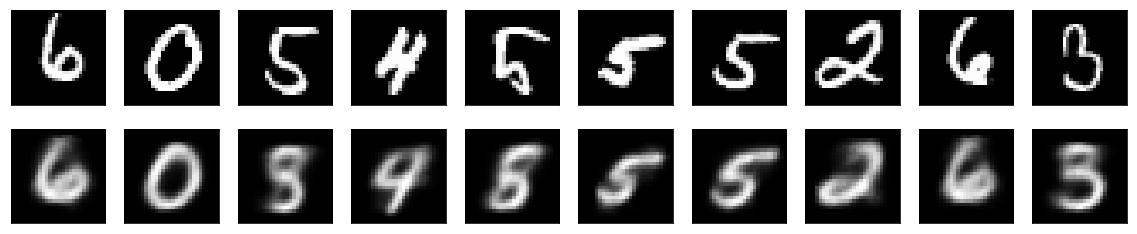

In [8]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist.test.images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(vi.encode(mnist.test.images[i]).reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()